In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter, WeibullAFTFitter, KaplanMeierFitter
from sksurv.metrics import concordance_index_ipcw, concordance_index_censored
from sksurv.util import Surv
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression


from typing import Optional, Dict, Any


# 1) Hiểu dữ liệu & mục tiêu

**Đầu vào**:  
- `clinical_train.csv`: Đặc trưng lâm sàng (BM_BLAST, WBC, ANC, MONOCYTES, HB, PLT, …) + ID.  
- `molecular_train.csv`: Đột biến gen (GENE, EFFECT, VAF, …) + ID (nhiều dòng/bệnh nhân).  
- `target_train.csv`: Nhãn survival (OS_YEARS, OS_STATUS) + ID.  

**Đầu ra**: Mô hình dự báo rủi ro (CoxPH, Weibull AFT); C-index; phân tầng KM theo decile; calibration xác suất sống sót tại mốc (1y, 2y, 3y).

## 🧬 1. `clinical_train.csv` — Dữ liệu lâm sàng
Mỗi dòng = 1 bệnh nhân tại chẩn đoán, chứa thông tin huyết học, trung tâm, cytogenetics.

| Cột | Ý nghĩa | Vai trò |
|-----|---------|---------|
| **ID** | Mã bệnh nhân duy nhất | Merge bảng; không dùng làm feature. |
| **CENTER** | Trung tâm y tế (MSK, DFCI, …) | Kiểm tra bias; strata nếu cần. |
| **BM_BLAST** | % blast tủy xương | ↑ → tiên lượng xấu (xâm lấn cao). |
| **WBC** | Bạch cầu máu ngoại vi (×10⁹/L) | ↑ → gánh nặng bệnh, biến chứng. |
| **ANC** | Neutrophil tuyệt đối | ↓ → nhiễm trùng, xấu. |
| **MONOCYTES** | Bạch cầu đơn nhân | Liên quan AML M4/M5. |
| **HB** | Hemoglobin (g/dL) | ↓ → thiếu máu, xấu. |
| **PLT** | Tiểu cầu (×10⁹/L) | ↓ → xuất huyết, xấu. |
| **CYTOGENETICS** | Nhiễm sắc thể (e.g., del(20), t(3;9)) | Trích xuất ELN risk (3q, 5q, 7q bất thường). |

**Ví dụ**:
| ID | CENTER | BM_BLAST | WBC | ANC | MONOCYTES | HB | PLT | CYTOGENETICS |
|----|--------|----------|-----|-----|-----------|----|-----|--------------|
| P132697 | MSK | 14.0 | 2.8 | 0.2 | 0.7 | 7.6 | 119 | 46,xy,del(20)(q12)[2]/46,xy[18] |
| P132700 | MSK | 6.0 | 128 | 9.7 | 0.9 | 11.1 | 195 | 46,xx,t(3;9)(p13;q22)[10]/46,xx[10] |

## 🧫 2. `molecular_train.csv` — Dữ liệu đột biến gen
Mỗi dòng = 1 đột biến/bệnh nhân (variant-level).

| Cột | Ý nghĩa | Cách sử dụng |
|-----|---------|--------------|
| **ID** | Mã bệnh nhân | Groupby để tổng hợp. |
| **CHR/START/END** | Vị trí nhiễm sắc thể | Không cần (trừ genomic feature). |
| **REF/ALT** | Allele gốc/thay thế | Tham chiếu; không huấn luyện. |
| **GENE** | Gene đột biến (TP53, NPM1, …) | Tạo binary (có/không). |
| **PROTEIN_CHANGE** | Thay đổi protein (p.R1262L) | Phân loại missense/truncating. |
| **EFFECT** | Loại (missense, frameshift, …) | Gộp deleterious/neutral. |
| **VAF** | % allele đột biến | Định lượng (clone size). |
| **DEPTH** | Read depth | Kiểm tra chất lượng. |

**Ví dụ**:
| ID | GENE | EFFECT | VAF | DEPTH |
|----|------|--------|-----|-------|
| P100000 | CBL | non_synonymous_codon | 0.083 | 1308 |
| P100000 | DNMT3A | frameshift_variant | 0.0898 | 942 |
| P100000 | TET2 | non_synonymous_codon | 0.43 | 826 |

### 📊 Tổng hợp theo bệnh nhân (groupby ID)
| Đặc trưng | Cách tính | Ý nghĩa |
|-----------|-----------|---------|
| `n_genes` | Số gene đột biến duy nhất | Phức tạp di truyền. |
| `vaf_mean` | Trung bình VAF | Clone trung bình. |
| `vaf_max` | VAF cao nhất | Major clone. |
| `TP53_mut`, `NPM1_mut`, … | 1 nếu có đột biến | Phân tầng tiên lượng. |

## ⏱️ 3. `target_train.csv` — Dữ liệu survival
| Cột | Ý nghĩa | Vai trò |
|-----|---------|---------|
| **ID** | Mã bệnh nhân | Merge. |
| **OS_YEARS** | Thời gian sống/theo dõi (năm) | Duration cho survival model. |
| **OS_STATUS** | 1=tử vong; 0=kiểm duyệt | Event cho survival model. |

## 🔗 4. Mối quan hệ bảng
| Bảng | Quan hệ | Mục đích |
|------|---------|----------|
| `clinical_train.csv` | 1 dòng = 1 bệnh nhân | Lâm sàng. |
| `molecular_train.csv` | Nhiều dòng = 1 bệnh nhân | Phân tử (tổng hợp). |
| `target_train.csv` | 1 dòng = 1 bệnh nhân | Outcomes. |

**Sau merge theo ID**:
| ID | BM_BLAST | WBC | HB | PLT | n_genes | vaf_max | OS_YEARS | OS_STATUS |
|----|----------|-----|----|-----|---------|---------|----------|-----------|
| P100000 | 14.0 | 2.8 | 7.6 | 119 | 4 | 0.43 | 5.2 | 1 |
| P132700 | 6.0 | 128 | 11.1 | 195 | 3 | 0.52 | 8.4 | 0 |

## 🧠 5. Ý nghĩa y học
| Biến | Loại | Ý nghĩa lâm sàng | Ảnh hưởng |
|------|------|------------------|-----------|
| **BM_BLAST** | Clinical | Xâm lấn tủy | ↑ → xấu |
| **WBC** | Clinical | Gánh nặng bệnh | ↑ → xấu |
| **HB** | Clinical | Thiếu máu | ↓ → xấu |
| **PLT** | Clinical | Xuất huyết | ↓ → xấu |
| **n_genes** | Molecular | Phức tạp di truyền | ↑ → xấu |
| **vaf_max** | Molecular | Clone chính | ↑ → xấu |
| **TP53_mut** | Molecular | Ác tính cao | ↑ → xấu |
| **NPM1_mut**, **CEBPA_mut**, **IDH1/2_mut** | Molecular | Thuận lợi | ↓ → tốt |

In [118]:
clinical = pd.read_csv("./data/clinical_train.csv")
molecular = pd.read_csv("./data/molecular_train.csv")
target = pd.read_csv("./data/target_train.csv")


In [119]:
clinical.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [120]:
molecular.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


In [121]:
target.head()

,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,1.0
1,P132698,4.928767,0.0
2,P116889,2.043836,0.0
3,P132699,2.476712,1.0
4,P132700,3.145205,0.0


# 2) Chuẩn hóa nhãn & hợp nhất dữ liệu


* Ghép `clinical` với `target` theo `ID`.
* Từ `molecular`, tổng hợp theo **bệnh nhân** (theo `ID`):

  * Số gene khác nhau (`n_genes`), trung bình/đỉnh VAF (`vaf_mean`, `vaf_max`).
  * (Tuỳ chọn) Đếm biến theo EFFECT (missense/stop_gained/frameshift/splice…), và one-hot các gene AML quan trọng (NPM1, FLT3, TP53, DNMT3A, IDH1/2, RUNX1, TET2, NRAS, KRAS, CEBPA).
* Merge đặc trưng phân tử đã tổng hợp vào bảng lâm sàng–mục tiêu → tạo **bảng làm việc**.


In [122]:

t = target.copy()
# t["OS_STATUS_BIN"] = t["OS_STATUS"].fillna(0)

clin = clinical.merge(t[["ID","OS_YEARS","OS_STATUS"]], on="ID", how="left")

# Tổng hợp phân tử
agg_f = molecular.groupby("ID").agg(
    n_genes=("GENE","nunique"),
    vaf_mean=("VAF","mean"),
    vaf_max=("VAF","max")
).reset_index()
agg_f


,ID,n_genes,vaf_mean,vaf_max
0,P100000,6,0.301300,0.7730
1,P100001,2,0.259500,0.4180
2,P100002,2,0.397000,0.5970
3,P100004,1,0.469100,0.4691
4,P100006,5,0.169300,0.3720
...,...,...,...,...
3021,P132725,5,0.533600,0.8060
3022,P132726,1,0.269000,0.2690
3023,P132727,2,0.322250,0.3595
3024,P132728,4,0.442640,0.4580


In [123]:
# Gộp
full = clin.merge(agg_f, on="ID", how="left")
full = full.fillna(0)
full


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,OS_YEARS,OS_STATUS,n_genes,vaf_mean,vaf_max
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.115068,1.0,8.0,0.251578,0.4220
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,"46,xx",4.928767,0.0,3.0,0.272867,0.2825
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",2.043836,0.0,3.0,0.039333,0.0480
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",2.476712,1.0,9.0,0.209227,0.4770
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",3.145205,0.0,1.0,0.472100,0.4721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3318,P121828,VU,1.0,3.70,2.53,0.53,8.9,499.0,"46,xy[20]",0.000000,0.0,2.0,0.397000,0.4100
3319,P121829,VU,0.0,4.20,2.40,0.22,10.6,49.0,"46,xy,del(13)(q12q14)[1]/45,x,-y,del(13)(q12q1...",0.000000,0.0,1.0,0.042000,0.0420
3320,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,"46,xy,del(20)(q11.2q13.1)[4]/45,xy,idem,-7[16]",1.997260,0.0,6.0,0.244650,0.4390
3321,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,"46,xx,del(1)(p34)[5]/45,xx,sl,-18[12]/46,xx,sd...",0.095890,1.0,3.0,0.184250,0.2690



# 3) Làm sạch & tiền xử lý đặc trưng

1. **Giá trị thiếu và vô hạn**

   * Thay thế `±inf` bằng thiếu; điền thiếu cho biến giải thích (gợi ý: median) nhưng **không điền** cho `OS_YEARS`, `OS_STATUS_BIN`.
2. **Thời gian không dương**

   * Với AFT, yêu cầu `OS_YEARS > 0`. Nếu có giá trị ≤ 0, cộng một epsilon rất nhỏ để đảm bảo dương.
3. **Xử lý độ lệch & ngoại lai**

   * Biến rất lệch (WBC, ANC, PLT, VAF…) nên **log1p** hoặc biến đổi tương tự.
   * **Winsorize**/clip biên mỏng (ví dụ 0.5%–99.5%) để giảm ảnh hưởng ngoại lai cực trị.
4. **Loại biến kém thông tin**

   * Loại biến **phương sai gần 0** hoặc **hầu như chỉ một giá trị** (nhiễu).
5. **Giảm đa cộng tuyến**

   * Kiểm tra ma trận tương quan; loại một trong hai biến có |ρ| quá cao (ví dụ > 0.95).
   * (Tuỳ chọn) Tính **VIF**, loại dần biến có VIF quá lớn (ví dụ > 10).
6. **Chuẩn hóa thang đo**

   * Scale (z-score) tất cả đặc trưng đầu vào để ổn định tối ưu hóa, tiện so sánh hệ số.


In [124]:

duration_col = "OS_YEARS"
event_col    = "OS_STATUS"
features     = ["BM_BLAST","WBC","ANC","MONOCYTES","HB","PLT","n_genes","vaf_mean","vaf_max"]

In [125]:

df = full[[duration_col, event_col] + features].copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)



In [126]:

# điền thiếu X, đảm bảo y có mặt
for c in features:
    df[c] = df[c].fillna(df[c].median())
df = df.dropna(subset=[duration_col, event_col])


In [127]:

# nếu có thời gian <=0, đẩy lên epsilon cho AFT
epsilon = 1e-6
df.loc[df[duration_col] <= 0, duration_col] = epsilon

In [128]:

# kiểm tra tổng event trước khi làm bất cứ điều gì
n_events_total = int(df[event_col].sum())
print("\nTổng event sau merge/clean:", n_events_total, "/", len(df))
if n_events_total == 0:
    raise RuntimeError("DỮ LIỆU KHÔNG CÓ EVENT: Survival analysis bất khả thi. Kiểm tra lại OS_STATUS gốc.")



Tổng event sau merge/clean: 1600 / 3323


In [129]:
for c in ["WBC","ANC","PLT","vaf_mean","vaf_max"]:
    if c in df.columns:
        df[c] = np.log1p(df[c])

low_q, high_q = 0.005, 0.995
for c in features:
    lo, hi = df[c].quantile(low_q), df[c].quantile(high_q)
    df[c] = df[c].clip(lo, hi)


In [130]:

# drop near-zero variance
nzv = [c for c in features if (df[c].std() < 1e-8 or df[c].nunique() <= 2)]
features = [c for c in features if c not in nzv]


In [131]:

# drop high corr
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones_like(corr), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
features = [c for c in features if c not in to_drop]

In [132]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

print("\nFeatures giữ lại:", features)
print("Event rate:", df[event_col].mean())


Features giữ lại: ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'n_genes', 'vaf_mean', 'vaf_max']
Event rate: 0.48149262714414687


# 5) Chia tập dữ liệu đảm bảo có sự kiện

**Vấn đề**: Dữ liệu survival dễ mất cân bằng khi random split, dẫn đến test set thiếu sự kiện (N₁^(test) = 0).

**Xử lý**: Phân tầng theo sự kiện (δ_i) để giữ tỷ lệ tử vong r = N₁/N tương đương giữa train/test:
\[
\frac{N_1^{(train)}}{N^{(train)}} \approx \frac{N_1^{(test)}}{N^{(test)}} \approx r.
\]

Thuật toán phân tầng:
1. Chia dữ liệu: D₁ = {i: δ_i=1}, D₀ = {i: δ_i=0}.
2. Lấy mẫu ngẫu nhiên tỷ lệ p từ mỗi nhóm: D₁^(train) = sample(D₁, p), D₀^(train) = sample(D₀, p).
3. Gộp: D^(train) = D₁^(train) ∪ D₀^(train); D^(test) = D \ D^(train).

→ Đảm bảo phân phối sự kiện tương tự.

**Ràng buộc**: Train/test ≥ N_min sự kiện (N_min ≈ 5–10). Nếu thiếu ở test: giảm test_size hoặc chuyển vài event từ train sang test.

**Với dữ liệu nhỏ/r hiếm** (N₁^(test/train) < N_min):  
- (a) Giảm test_size (e.g., 0.3 → 0.2).  
- (b) Chuyển ngẫu nhiên event từ train sang test đến đủ.  

→ Đảm bảo tính hợp lệ cho mô hình Cox/AFT.

In [133]:

def stratified_surv_split(df, event_col="OS_STATUS",
                          test_size=0.25, min_events_test=5,
                          max_tries=80, random_state=123):
    y = df[event_col].astype(int).values
    ts = test_size
    for i in range(max_tries):
        tr, te = train_test_split(df, test_size=ts, random_state=random_state+i, stratify=y)
        if tr[event_col].sum() >= min_events_test and te[event_col].sum() >= min_events_test:
            return tr, te
        ts = max(0.10, ts - 0.05)
    return tr, te  # fallback

train_df, test_df = stratified_surv_split(df, event_col=event_col, test_size=0.25, min_events_test=5)
print("events train/test:", int(train_df[event_col].sum()), int(test_df[event_col].sum()))

# nếu vẫn đen đủi, ép chuyển 1 ít event sang test:
if test_df[event_col].sum() == 0 and train_df[event_col].sum() > 0:
    pos_idx = train_df[train_df[event_col]==1].sample(n=min(5, int(train_df[event_col].sum())), random_state=7).index
    move_rows = train_df.loc[pos_idx]
    train_df = train_df.drop(index=pos_idx)
    test_df  = pd.concat([test_df, move_rows], axis=0)

print("events train/test (after fix):", int(train_df[event_col].sum()), int(test_df[event_col].sum()))


events train/test: 1200 400
events train/test (after fix): 1200 400



# 6) Huấn luyện mô hình


In [134]:
Xcols        = features  # đã chuẩn bị ở các bước trước

--------------------

## 6.1) Fit models 

### 6.1.1) Cox Proportional Hazards (CoxPH)

**Mô tả ngắn**: Thêm **ridge penalizer** nhỏ (L2) để ổn định khi đa cộng tuyến/ít sự kiện. Lấy **partial hazard** làm thước điểm rủi ro.

CoxPH là mô hình cốt lõi cho survival analysis, ước lượng tác động của đặc trưng (X) lên hazard rate theo thời gian.

🧩 Mục tiêu

Hazard cho cá thể i:
\[
h_i(t \mid X_i) = h_0(t) \exp(\beta^\top X_i)
\]
- \(h_0(t)\): baseline hazard.
- \(\beta\): hệ số cần học.
- Giả định: hazard tỉ lệ cố định giữa các cá thể (proportional hazards).

📐 Partial Likelihood

Ước lượng \(\beta\) bằng partial likelihood (bỏ qua \(h_0(t)\)):
\[
L(\beta) = \prod_{i:\delta_i=1} \frac{\exp(\beta^\top X_i)}{\sum_{j \in R(T_i)} \exp(\beta^\top X_j)}
\]
Log-likelihood:
\[
\ell(\beta) = \sum_{i:\delta_i=1} \left[ \beta^\top X_i - \log \sum_{j \in R(T_i)} \exp(\beta^\top X_j) \right]
\]
Tối đa hóa \(\ell(\beta)\) để được \(\hat{\beta}\).

⚠️ Vấn đề

Với p biến ≈ N₁ sự kiện hoặc multicollinearity (e.g., WBC ~ BM_BLAST), ma trận Hessian \(H = X^\top W X\) gần singular → không hội tụ.

🧮 Ridge Penalization (L2)

Thêm penalty:
\[
\ell_{ridge}(\beta) = \ell(\beta) - \frac{\lambda}{2} \|\beta\|_2^2 \quad (\lambda \in [0.01, 0.5])
\]
→ Ổn định \(\hat{\beta}\), giảm overfitting, làm mượt trọng số.

⚙️ Partial Hazard (Risk Score)

\[
\text{partial hazard}_i = \exp(\hat{\beta}^\top X_i), \quad \text{risk score}_i = \hat{\beta}^\top X_i
\]
- So sánh: Nếu risk score_i > risk score_j → i nguy cơ cao hơn j.
- HR giữa i và j: \(\exp(\hat{\beta}^\top (X_i - X_j))\).
- Ứng dụng: Phân nhóm (Kaplan–Meier), C-index, calibration plot.

🔧 Quy trình thực hành

| Bước | Mục tiêu | Thực hiện |
|------|----------|-----------|
| 1. Z-score X | Tránh biến lớn lấn át | \(X_j' = \frac{X_j - \mu_j}{\sigma_j}\) |
| 2. Ridge nhỏ | Ổn định | `CoxPHFitter(penalizer=0.1, robust=True)` |
| 3. Kiểm tra hội tụ | Tránh singular | Giảm biến/tăng λ nếu cần |
| 4. Predict | Xuất risk | `cph.predict_partial_hazard(X_test)` |

📊 Ví dụ kết quả

| Biến | \(\hat{\beta}\) | HR = exp(\(\hat{\beta}\)) | Diễn giải |
|------|-----------------|---------------------------|-----------|
| BM_BLAST | +0.031 | 1.03 | +1% blast → hazard ↑3% |
| WBC | +0.008 | 1.01 | WBC ↑ → nguy cơ ↑ nhẹ |
| PLT | -0.004 | 0.996 | Tiểu cầu cao → giảm nguy cơ |
| TP53_mut | +0.85 | 2.34 | Có mut → nguy cơ gấp 2.3 |

🔢 Tổng kết

| Thành phần | Biểu thức | Ý nghĩa |
|------------|-----------|---------|
| Hazard | \(h_i(t) = h_0(t) e^{\beta^\top X_i}\) | Tốc độ tử vong tức thời |
| Log partial-LL | \(\sum [\beta^\top X_i - \log \sum e^{\beta^\top X_j}]\) | Ước lượng \(\beta\) |
| Ridge penalty | \(-\frac{\lambda}{2}\|\beta\|_2^2\) | Ổn định multicollinearity |
| HR | \(e^{\beta^\top(X_i - X_j)}\) | So sánh nguy cơ |
| Partial hazard | \(\exp(\beta^\top X_i)\) | Risk score xếp hạng |

**Kết luận**: CoxPH ước lượng ảnh hưởng tương đối của X lên nguy cơ. Ridge nhỏ ổn định khi ít sự kiện/đa cộng tuyến. Partial hazard dùng làm risk score cho phân tầng, KM curve, C-index/calibration.

In [135]:

# Cox (ridge để tránh singular)
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_df[[duration_col, event_col] + Xcols],
        duration_col=duration_col, event_col=event_col, robust=True)
risk_cox = cph.predict_partial_hazard(test_df[Xcols]).values.ravel()
risk_cox

array([0.37915333, 0.88771867, 1.86126104, 0.44531026, 0.77186033,
       0.79114692, 1.4097012 , 0.73299687, 2.96965177, 0.69587907,
       1.34294699, 1.61478618, 0.89927736, 0.80330438, 0.90709761,
       1.06373356, 1.03026012, 1.48130055, 1.45586786, 1.47605757,
       1.55666542, 0.61329225, 1.0342529 , 0.73466989, 0.74047696,
       0.71725764, 0.34550427, 1.10611717, 0.59989374, 1.15891535,
       1.07855826, 0.74558794, 1.59291743, 1.57608853, 1.00219492,
       1.31785669, 1.64710335, 0.49838544, 0.63432297, 0.75354969,
       1.0336777 , 0.8081152 , 3.19078929, 1.32896075, 1.20456651,
       0.72877406, 0.95845837, 0.87124668, 1.01867906, 1.43237011,
       0.72615073, 1.05218489, 0.71947502, 3.0055075 , 0.65912445,
       0.87732539, 0.69612448, 0.42497377, 0.46062881, 0.79818099,
       4.82514726, 0.53169196, 0.63591156, 0.60733859, 0.77646069,
       0.88148239, 0.53466347, 0.77414453, 1.06849042, 1.60065155,
       1.50211184, 0.7139439 , 0.40423075, 0.41143048, 1.46324

### 6.1.2) Weibull Accelerated Failure Time (AFT)

**Mô tả ngắn**: Phù hợp khi CoxPH khó hội tụ hoặc giả định PH không tốt. Dùng **median predicted survival time**; đảo dấu để có “risk score” (thời gian nhỏ → rủi ro cao).

Weibull AFT là mô hình parametric thay thế Cox, mô hình hóa trực tiếp thời gian sống (T) thay vì hazard tương đối.

🧩 Mục tiêu

Log thời gian sống:
\[
\log(T_i) = \beta^\top X_i + \sigma \epsilon_i
\]
- \(X_i\): đặc trưng; \(\beta\): hệ số; \(\sigma > 0\): scale; \(\epsilon_i\): nhiễu (Gumbel cho Weibull).

📐 Survival & Hazard

Hàm sống sót:
\[
S(t \mid X) = \exp\left[-\left(\frac{t}{\lambda(X)}\right)^{\kappa}\right], \quad \lambda(X) = \exp(\beta^\top X), \quad \kappa = 1/\sigma
\]
Hazard:
\[
h(t \mid X) = \frac{\kappa}{\lambda(X)} \left(\frac{t}{\lambda(X)}\right)^{\kappa - 1}
\]
- \(\kappa = 1\): hazard không đổi; \(\kappa > 1\): tăng dần; \(\kappa < 1\): giảm dần.

🧮 Ước lượng

Maximum likelihood trên dữ liệu censored:
\[
\ell(\beta, \sigma) = \sum_i \left[ \delta_i \log f(T_i \mid X_i) + (1-\delta_i) \log S(T_i \mid X_i) \right]
\]
Thực hiện: `WeibullAFTFitter().fit(df, duration_col="OS_YEARS", event_col="OS_STATUS_BIN")` (lifelines).

📈 Median Survival

\[
t_{0.5}(X) = \lambda(X) (\ln 2)^{1/\kappa} = e^{\beta^\top X} (\ln 2)^{1/\kappa}
\]
Dự báo: `aft.predict_median(X_test)`.

⚖️ Risk Score

Đảo dấu để risk cao → sống ngắn:
\[
\text{risk}_i = -t_{0.5}(X_i) \propto -\exp(\beta^\top X_i)
\]

🧠 Khi dùng AFT thay Cox

| Tình huống | Lý do | Lợi ích AFT |
|------------|-------|-------------|
| Cox không hội tụ | Hessian singular, ít sự kiện | Parametric ổn định |
| Vi phạm PH | HR thay đổi theo thời gian | Không cần PH |
| Cần thời gian tuyệt đối | Cox chỉ tương đối | Dự báo T trực tiếp |
| Dữ liệu nhỏ | Biến tương quan mạnh | Tận dụng form parametric |

⚙️ Quy trình thực hành

| Bước | Mục tiêu | Thực hiện |
|------|----------|-----------|
| 1. Chuẩn hóa X | Hội tụ dễ | Z-score/log-transform |
| 2. Chọn Weibull | Phân phối phù hợp | `WeibullAFTFitter()` |
| 3. Fit ML | Ước lượng \(\beta, \sigma\) | `aft.fit(...)` |
| 4. Predict median | Dự báo cá nhân | `aft.predict_median(X_test)` |
| 5. Đảo dấu risk | So sánh với Cox | `risk = -predict_median` |
| 6. Đánh giá | Phân tầng | C-index/KM plot |

📊 So sánh CoxPH vs. Weibull AFT

| Đặc tính | **CoxPH** | **Weibull AFT** |
|----------|-----------|-----------------|
| Mục tiêu | Hazard tương đối | Thời gian tuyệt đối |
| Hazard | \(h_0(t) e^{\beta^\top X}\) | \(\frac{\kappa}{\lambda} (t/\lambda)^{\kappa-1}\) |
| Giả định PH | Có | Không bắt buộc |
| Baseline | Không xác định | Weibull parametric |
| Risk score | \(\exp(\beta^\top X)\) | \(-t_{0.5} = -e^{\beta^\top X} (\ln 2)^{1/\kappa}\) |
| Dự báo T tuyệt đối | Không | Có (median/mean) |
| Ổn định dữ liệu nhỏ | Trung bình | Tốt hơn |

🧩 Ý nghĩa thực tế (AML)

- \(\hat{t}_{0.5,i} < 2\) năm: high risk; \(>5\): low risk.
- Dùng –median làm risk cho KM, C-index, calibration.

**Kết luận**: Weibull AFT parametric mô hình hóa T trực tiếp, ổn định khi Cox khó hội tụ/PH vi phạm. Ước lượng median survival, đảo dấu thành risk score cho phân tầng, đánh giá tương tự Cox.

In [136]:
# Weibull AFT
aft = WeibullAFTFitter()
aft.fit(train_df[[duration_col, event_col] + Xcols],
        duration_col=duration_col, event_col=event_col)
# median time nhỏ -> rủi ro lớn
risk_aft = -aft.predict_median(test_df[Xcols]).values.ravel()
risk_aft

array([-10.41136746,  -3.90450592,  -1.57518781,  -8.7241478 ,
        -4.59471177,  -4.34794895,  -2.30052075,  -4.74442822,
        -0.97813572,  -5.16177229,  -2.40038683,  -1.82262666,
        -3.86490394,  -4.43452534,  -3.83405363,  -3.21389265,
        -3.13131076,  -2.21153316,  -2.15537828,  -2.20028638,
        -2.04030187,  -5.93165083,  -3.35535041,  -4.88735199,
        -4.74485337,  -5.17218357, -11.61282674,  -3.03949647,
        -6.08708927,  -2.83062774,  -3.05843353,  -4.77990571,
        -2.05614555,  -1.98093425,  -3.43446323,  -2.46109144,
        -1.95153824,  -7.72156839,  -5.89845254,  -4.81929541,
        -3.29155124,  -4.47766899,  -0.92640222,  -2.55482512,
        -2.75099495,  -5.09195948,  -3.57174144,  -4.00468607,
        -3.35233992,  -2.24384421,  -4.96278248,  -3.42338981,
        -5.21474641,  -0.95401399,  -5.58527773,  -4.1069389 ,
        -5.19823299,  -9.13343575,  -8.44884327,  -4.36739591,
        -0.58362589,  -6.92877314,  -5.77113671,  -6.07

# 3) Kiểm tra giả định PH (sau khi fit Cox)

**Mô tả ngắn**: Dùng kiểm định/đồ thị Schoenfeld để xem biến nào vi phạm PH; vi phạm nặng → cân nhắc **stratification** (phân tầng theo biến) hoặc **time-varying effects**.

Kiểm tra giả định proportional hazards (PH) là bước bắt buộc sau fit CoxPH, đảm bảo hazard ratio cố định theo thời gian.

## 🧠 Bối cảnh & Ý nghĩa
CoxPH giả định:
\[
h(t \mid X) = h_0(t) \exp(\beta^\top X) \implies \frac{h(t \mid X_i)}{h(t \mid X_j)} = \exp[\beta^\top (X_i - X_j)]
\]
HR không phụ thuộc t. Vi phạm → \(\beta\) sai lệch.

## 📉 Khi vi phạm PH
| Biến | Dấu hiệu | Lý do lâm sàng |
|------|----------|----------------|
| WBC | Hazard cao đầu, giảm dần | Tử vong sớm; sống sót sau → tiên lượng bình thường |
| TP53_mut | Ảnh hưởng mạnh đầu, giảm | Điều trị đảo ngược nguy cơ |
| CENTER | Chiến lược thay đổi theo t | Vi phạm theo trung tâm |

## 🧮 Schoenfeld Residual Test
Phần dư:
\[
r_{ij} = x_{ij} - \frac{\sum_{k \in R(T_i)} x_{kj} e^{\beta^\top x_k}}{\sum_{k \in R(T_i)} e^{\beta^\top x_k}}
\]
- Nếu PH đúng: \(r_{ij}\) ngẫu nhiên quanh 0, không phụ thuộc t.
- Vi phạm: \(r_{ij}\) xu hướng theo t.

## 🧪 Grambsch–Therneau Test
Kiểm tra: \(H_0: \Cov(r_{ij}, \log t_i) = 0\).
p < 0.05 → vi phạm. Global: \(\chi^2_{\text{global}} = \sum_j \chi^2_j\).

Triển khai (lifelines):
```python
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, train_df, time_transform='rank')
results.print_summary(decimals=3)
```

Ví dụ:
| Biến | \(\chi^2\) | p | Vi phạm? |
|------|------------|---|----------|
| BM_BLAST | 1.22 | 0.27 | Không |
| WBC | 5.45 | 0.019 | ✅ Có |
| PLT | 0.31 | 0.58 | Không |
| TP53_mut | 4.92 | 0.027 | ✅ Có |
| **Global** | 8.77 | 0.031 | ⚠️ Nhẹ |

## 📊 Đồ thị kiểm tra
```python
cph.check_assumptions(train_df, show_plots=True)
```
- X: log(t); Y: residuals.
- Đường xanh phẳng → OK; nghiêng → vi phạm (e.g., WBC dốc xuống).

## 🧩 Xử lý vi phạm
### 7.1 Stratification
Biến phân loại (e.g., CENTER):
\[
h(t \mid X, \text{strata}) = h_{0,\text{strata}}(t) \exp(\beta^\top X)
\]
```python
cph.fit(df, ..., strata=["CENTER"])
```

### 7.2 Time-varying Effects
Biến định lượng (e.g., WBC):
\[
\beta_j(t) = \beta_j + \gamma_j \log t
\]
```python
df["WBC_logt"] = df["WBC"] * np.log(df["OS_YEARS"])
cph.fit(df, ...)
```

### 7.3 Piecewise Cox
Chia khoảng thời gian (0–2y, 2–5y, >5y); fit riêng từng giai đoạn.

🧾 Kết quả diễn giải
| Biến | p-value | Vi phạm? | Biện pháp |
|------|---------|----------|-----------|
| BM_BLAST | 0.27 | ❌ Không | Giữ nguyên |
| WBC | 0.019 | ✅ Có | Tương tác log(t) |
| TP53_mut | 0.027 | ✅ Có | Stratify/time-varying |
| Global | 0.031 | ⚠️ Nhẹ | Kiểm tra thêm |

**Kết luận**: Kiểm tra PH qua Schoenfeld test/đồ thị đảm bảo mô hình đáng tin. Vi phạm nhẹ: ghi nhận; mạnh: stratify/time-varying để sửa, giữ ý nghĩa HR cố định hoặc điều chỉnh.

# 7) Đánh giá phân biệt: C-index (ưu tiên Uno’s C)

**Mô tả ngắn**:  
1. **Uno’s C** (IPCW): Đo phân biệt khi có kiểm duyệt; cần cohort tham chiếu để ước xác suất kiểm duyệt. Nếu train không đủ → dùng test làm tham chiếu.  
2. **Fallback Harrell’s C**: Nếu test không có sự kiện hoặc IPCW lỗi (ít mẫu sau lọc) → dùng Harrell’s C dự phòng.  
3. **Vệ sinh đầu vào**: Loại NaN/Inf ở thời gian/sự kiện/risk; nếu risk không phương sai → C-index kém ý nghĩa, ghi chú.

C-index đo khả năng phân biệt thứ hạng rủi ro trong survival model. Ưu tiên Uno’s C để điều chỉnh censoring; fallback Harrell’s nếu cần.

🧩 Mục tiêu C-index
Đo tỷ lệ cặp bệnh nhân concordant: risk cao → chết sớm.  
Với i, j: comparable nếu \(T_i < T_j\) và \(\delta_i = 1\).  
Concordant nếu \(r_i > r_j\).  
\[
C = \frac{\text{Số cặp concordant}}{\text{Số cặp hợp lệ}}
\]
- C=1: hoàn hảo; C=0.5: ngẫu nhiên; C<0.5: ngược.

⚖️ Vấn đề censoring

Censoring (\(\delta_i=0\)) làm mất cặp so sánh → biased. Giải pháp: Uno’s C (IPCW) dùng trọng số nghịch đảo.

🧠 Uno’s C (IPCW)

Ước lượng \(G(t) = P(C > t)\) bằng Kaplan–Meier trên cohort tham chiếu (thường train). Nếu train ít sự kiện → dùng test.  
\[
C_{Uno} = \frac{\sum_{i \neq j} I(T_i < T_j) I(\delta_i=1) \frac{I(r_i > r_j)}{G(T_i)^2}}{\sum_{i \neq j} I(T_i < T_j) I(\delta_i=1) \frac{1}{G(T_i)^2}}
\]
Trọng số \(1/G(T_i)^2\) giảm bias.

🧩 Thực hành (sksurv)

```python
from sksurv.metrics import concordance_index_ipcw
y_train = Surv.from_arrays(event=train_df[event_col].astype(bool), time=train_df[duration_col])
y_test = Surv.from_arrays(event=test_df[event_col].astype(bool), time=test_df[duration_col])
c_uno, _ = concordance_index_ipcw(y_train, y_test, -risk_score, test_df[duration_col])
```

🧩 Fallback: Harrell’s C

Nếu test không sự kiện/IPCW lỗi:  
\[
C_{Harrell} = \frac{\sum_{i<j} I(T_i < T_j, \delta_i=1) I(r_i > r_j)}{\sum_{i<j} I(T_i < T_j, \delta_i=1)}
\]
```python
from sksurv.metrics import concordance_index_censored
c_harrell, _, _ = concordance_index_censored(events, times, -risk_score)
```

🧼 Vệ sinh đầu vào

| Kiểm tra | Lý do | Xử lý |
|----------|-------|-------|
| NaN/Inf ở T/δ/r | Lỗi công thức | Lọc `mask_valid = np.isfinite(...)` |
| Risk không phương sai | C vô nghĩa | Ghi chú “constant risk” |
| Tất cả event=0/1 | Không cặp hợp lệ | Log lỗi |

```python
mask_valid = np.isfinite(times) & np.isfinite(events) & np.isfinite(risk_score)
if np.var(risk_score) == 0: print("⚠️ No variance in risk; C meaningless.")
```

📊 Ghi chú báo cáo

Ghi loại C, cohort tham chiếu, sự kiện test.  
Ví dụ: `[uno] C=0.712 (ref: train; events:40) | [harrell-fallback] C=0.693`

🧠 Diễn giải

| C-index | Đánh giá | Diễn giải |
|---------|----------|-----------|
| <0.55 | Gần ngẫu nhiên | Không phân biệt |
| 0.55–0.65 | Yếu–TB | Tín hiệu yếu |
| 0.65–0.75 | Tốt | Phân biệt cao/thấp |
| 0.75–0.85 | Rất tốt | Đáng tin |
| >0.85 | Quá tốt | Kiểm tra overfit |

**Kết luận**: Uno’s C (IPCW) chuẩn nhất cho censoring, dùng trọng số để phục hồi bias. Fallback Harrell’s nếu không khả thi. Vệ sinh đầu vào đảm bảo ý nghĩa; kết hợp cho đánh giá nhất quán trên dữ liệu kiểm duyệt.

In [137]:
# ---------- 2) C-index helper ----------
def safe_cindex(times, events, preds, ref_times, ref_events, prefer="uno"):
    """
    Trả về (c_index, method_note).
    - Lọc NaN/Inf và căn chỉnh kích thước
    - Nếu test không có event -> Harrell
    - Nếu IPCW lỗi vì bất kỳ lý do gì -> fallback Harrell
    - Nếu vẫn không thể, trả về (np.nan, 'skip')
    """
    # ép về 1D
    times  = np.asarray(times).reshape(-1)
    events = np.asarray(events).reshape(-1).astype(int)
    preds  = np.asarray(preds).reshape(-1)

    # sanity mask test
    m_test = np.isfinite(times) & np.isfinite(events) & np.isfinite(preds)
    times2, events2, preds2 = times[m_test], events[m_test], preds[m_test]

    # không đủ mẫu để tính
    if times2.size < 2 or preds2.size < 2:
        return np.nan, "skip(test<2)"

    # nếu toàn cùng 1 giá trị dự báo -> c-index vô nghĩa
    if np.nanstd(preds2) == 0:
        # vẫn có thể trả Harrell (sẽ ~0.5 nếu ngẫu nhiên)
        try:
            res = concordance_index_censored(events2.astype(bool), times2, -preds2)
            return float(res[0]), "harrell(constant-score)"
        except Exception:
            return np.nan, "skip(constant-score)"

    # cohort tham chiếu để ước G(t); nếu train không đủ, dùng test
    ref_times  = np.asarray(ref_times).reshape(-1)
    ref_events = np.asarray(ref_events).reshape(-1).astype(int)
    m_ref = np.isfinite(ref_times) & np.isfinite(ref_events)
    ref_times2, ref_events2 = ref_times[m_ref], ref_events[m_ref]

    y_test = Surv.from_arrays(event=events2.astype(bool), time=times2.astype(float))
    if (ref_times2.size >= 2) and (ref_events2.sum() > 0):
        y_ref = Surv.from_arrays(event=ref_events2.astype(bool), time=ref_times2.astype(float))
    else:
        y_ref = y_test  # fallback: dùng test để ước censoring

    # không có event ở test -> Harrell
    if events2.sum() == 0:
        try:
            res = concordance_index_censored(events2.astype(bool), times2, -preds2)
            return float(res[0]), "harrell(no-event-test)"
        except Exception:
            return np.nan, "skip(no-event-test)"

    # Ưu tiên Uno’s C; nếu lỗi thì fallback Harrell
    if prefer == "uno":
        try:
            c, _ = concordance_index_ipcw(y_ref, y_test, -preds2, times2)
            return float(c), "uno"
        except Exception as e:
            # fallback: Harrell
            try:
                res = concordance_index_censored(events2.astype(bool), times2, -preds2)
                return float(res[0]), f"harrell(fallback:{type(e).__name__})"
            except Exception:
                return np.nan, "skip(fallback-failed)"
    else:
        # trực tiếp Harrell
        try:
            res = concordance_index_censored(events2.astype(bool), times2, -preds2)
            return float(res[0]), "harrell"
        except Exception:
            return np.nan, "skip(harrell-failed)"

# ---------- 3) Evaluate ----------
times, events = test_df[duration_col].values, test_df[event_col].values
ref_times, ref_events = train_df[duration_col].values, train_df[event_col].values

print(
    "Sanity before eval |",
    "len(times)=", len(times),
    "len(events)=", len(events),
    "len(risk_cox)=", len(risk_cox),
    "NaN risk_cox=", np.isnan(risk_cox).sum(),
    "Inf risk_cox=", np.isinf(risk_cox).sum()
)


Sanity before eval | len(times)= 831 len(events)= 831 len(risk_cox)= 831 NaN risk_cox= 0 Inf risk_cox= 0


một bước kiểm tra nhanh (“sanity check”) trước khi đánh giá C-index trong mô hình sống sót (survival).
Nó giúp bạn xác nhận rằng dữ liệu đầu vào cho phần đánh giá mô hình là hợp lệ, không bị thiếu hay lỗi.

In [138]:

c_cox, m1 = safe_cindex(times, events, risk_cox, ref_times, ref_events, prefer="uno")
c_aft, m2 = safe_cindex(times, events, risk_aft, ref_times, ref_events, prefer="uno")
print(f"[{m1}] C-index Cox = {c_cox:.3f} | [{m2}] C-index AFT = {c_aft:.3f}")


[harrell(fallback:ValueError)] C-index Cox = 0.299 | [harrell(fallback:ValueError)] C-index AFT = 0.302


# 8) Phân tầng rủi ro & trực quan hóa

**Mô tả ngắn**:  
* **Kaplan–Meier theo decile rủi ro**: Chia test thành 10 nhóm theo risk score (Cox); vẽ đường sống sót từng nhóm. Phân tách rõ (nhóm cao rơi nhanh) → mô hình phân biệt tốt.  
* (Tuỳ chọn) **KM theo đột biến**: So sánh có/không mutation (TP53, NPM1…); kèm log-rank test.

Phân tầng rủi ro bằng Kaplan–Meier (KM) theo decile risk score là cách trực quan hóa khả năng phân biệt của mô hình Cox/AFT.

## 🎯 Mục tiêu
Trực quan hóa phân biệt rủi ro: risk cao → đường sống rơi nhanh; risk thấp → đường sống cao lâu. Khoảng cách rõ → mô hình tốt cho lâm sàng.

## 🧩 Tính risk score
- **Cox**: \(r_i = \hat{\beta}^\top X_i\) (hoặc `predict_partial_hazard`).  
- **AFT**: \(r_i = -\hat{T}_{\text{median},i}\) (thời gian ngắn → risk cao).

## 📈 Phân tầng decile
Chia test thành 10 nhóm theo \(r_i\):  
\[
G_k = \{ i : q_{k-1} < r_i \le q_k \}, \quad k=1\dots10
\]  
(q_k: phân vị k/10). Nhóm 1: thấp; 10: cao.  
```python
test_df["risk_group"] = pd.qcut(risk_cox, q=10, labels=False) + 1
```

## 🧮 Kaplan–Meier estimator
Hàm sống sót cho nhóm k:  
\[
\hat{S}_k(t) = \prod_{t_i \le t} \left(1 - \frac{d_i^{(k)}}{n_i^{(k)}}\right)
\]  
- \(d_i^{(k)}\): tử vong tại t_i; \(n_i^{(k)}\): còn sống.  
Hazard cao → \(\hat{S}_k(t)\) giảm nhanh.

## 🧪 Thực hành (lifelines)
```python
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(7,5))
for g in sorted(test_df["risk_group"].unique()):
    mask = test_df["risk_group"] == g
    kmf.fit(test_df.loc[mask, "OS_YEARS"], 
            event_observed=test_df.loc[mask, "OS_STATUS_BIN"], 
            label=f"Decile {g}")
    kmf.plot_survival_function(ci_show=False)
plt.title("KM Curves by Risk Decile (Cox)")
plt.xlabel("Time (years)"); plt.ylabel("Survival probability")
plt.legend(title="Risk group (1=Low → 10=High)"); plt.grid(alpha=0.3)
plt.show()
```

## 🧠 Diễn giải
| Hiện tượng | Diễn giải |
|------------|-----------|
| Nhóm 10 rơi nhanh | Dự báo đúng high risk |
| Nhóm 1 ổn định | Tiên lượng tốt |
| Đường tách biệt, không giao | Phân tầng tốt |
| Đường chồng nhau | Không phân biệt |
| Dao động mạnh | Mẫu nhỏ → biến động |

## 🧾 Log-rank test
Xác nhận khác biệt: \(H_0: S_1(t) = \dots = S_{10}(t)\).  
```python
from lifelines.statistics import multivariate_logrank_test
results = multivariate_logrank_test(test_df["OS_YEARS"], test_df["risk_group"], 
                                    event_observed=test_df["OS_STATUS_BIN"])
results.print_summary()  # p < 0.05 → khác biệt ý nghĩa
```

## 📊 Biến thể
- Tertile/quartile (3–4 nhóm) nếu dữ liệu ít.  
- KM theo mutation (tuỳ chọn): So sánh có/không TP53/NPM1; log-rank test.  
  ```python
  kmf.fit(df[mut=="Yes"], "OS_YEARS", event_observed=..., label="TP53 mut")
  kmf.plot_survival_function()
  # Log-rank: logrank_test giữa 2 nhóm
  ```

## 🧮 Ví dụ kết quả
| Nhóm | Median survival (năm) | p-value |
|------|-----------------------|---------|
| Decile 1 (thấp) | 5.8 | |
| Decile 10 (cao) | 0.9 | <1e-6 |

Đồ thị: Nhóm 10 (đỏ) rơi <1 năm; nhóm 1 (xanh) >5 năm → phân tách mạnh.

**Kết luận**: KM theo decile risk score minh họa phân biệt rủi ro; đường tách rõ + log-rank thấp → mô hình mạnh, dễ diễn giải lâm sàng. Kết hợp C-index cho đánh giá toàn diện.

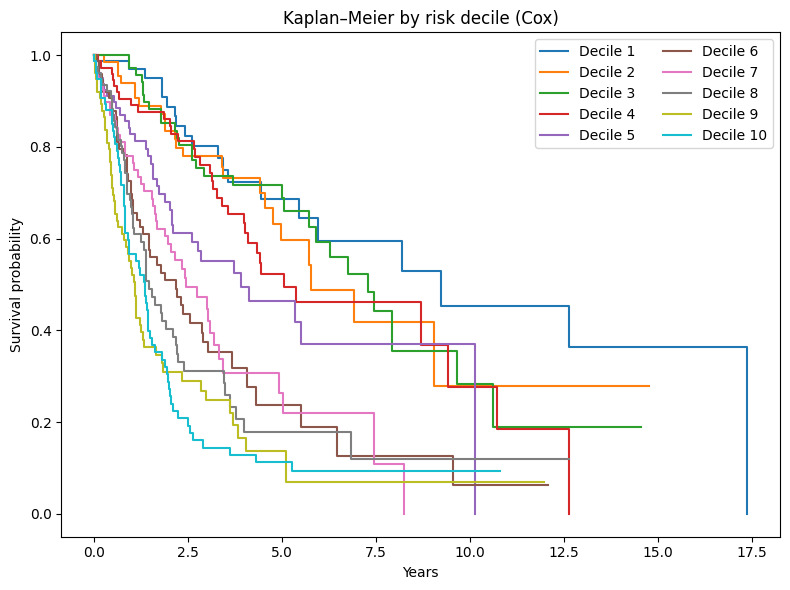

In [139]:
test_plot = test_df.copy()
test_plot["risk_cox"] = risk_cox
# trong trường hợp nhiều giá trị trùng, dùng duplicates="drop"
test_plot["decile"] = pd.qcut(test_plot["risk_cox"], q=10, labels=False, duplicates="drop")

plt.figure(figsize=(8,6))
km = KaplanMeierFitter()
for d in sorted(test_plot["decile"].unique()):
    grp = test_plot[test_plot["decile"] == d]
    if len(grp) < 5:  # nhóm quá ít thì bỏ qua
        continue
    km.fit(grp[duration_col].values, grp[event_col].values, label=f"Decile {int(d)+1}")
    km.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier by risk decile (Cox)")
plt.xlabel("Years"); plt.ylabel("Survival probability")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


# 9) Hiệu chỉnh xác suất tại mốc thời gian (calibration)

**Mô tả ngắn**:  
* Mục tiêu: Ước \(\hat{p}(t_0 \mid X) = P(T > t_0 \mid X)\) tại mốc lâm sàng (1y, 2y, 3y…).  
* **Xây biến nhị phân**: y=1 nếu sống qua t₀ (hoặc kiểm duyệt sau t₀); loại kiểm duyệt trước t₀.  
* **Hiệu chỉnh**: Platt (logistic sigmoid) cho bias S-shape, đơn giản; Isotonic (phi tham số) linh hoạt nhưng dễ overfit nếu dữ liệu ít.  
* **Đánh giá**: Vẽ **reliability diagram** (đường gần chéo 45° → tốt).  
* Khuyến nghị: Tách “calibration set” riêng hoặc cross-validation tránh quá khớp.

Hiệu chỉnh chuyển risk score → xác suất sống thực tế, đảm bảo predicted ≈ observed cho dự báo lâm sàng.

## 🎯 Mục tiêu
Dự đoán xác suất sống sót qua mốc t₀:  
\[
\hat{p}(t_0 \mid X) = \widehat{P}(T > t_0 \mid X)
\]  
Làm risk score khớp observed survival frequency.

## 🧩 Chuẩn bị dữ liệu
Tại t₀ (e.g., 1 year):  
\[
y_i = 
\begin{cases} 
1 & T_i > t_0 \ (sống/kiểm duyệt sau) \\ 
0 & T_i \le t_0, \ \delta_i=1 \ (tử vong trước) \\ 
\text{loại} & T_i \le t_0, \ \delta_i=0 \ (kiểm duyệt trước)
\end{cases}
\]  
→ \(\mathcal{D}_{cal} = \{(r_i, y_i)\}\), r_i = risk từ Cox/AFT.

## ⚙️ Phương pháp hiệu chỉnh
Tìm \(f: r_i \mapsto \hat{p}_i = P(T > t_0 \mid X_i)\).

### 🔹 Platt (logistic sigmoid)
Cho bias S-shape (quá lạc quan/bi quan hai đầu):  
\[
P(T > t_0 \mid X) = \frac{1}{1 + \exp(-(a + b r))}
\]  
Fit logistic trên \(\mathcal{D}_{cal}\).  
Ưu: Đơn giản, ít overfit. Nhược: Không linh hoạt phi tuyến.

### 🔹 Isotonic regression
Phi tham số, giữ monotonicity:  
\[
f^* = \arg\min_f \sum_i (f(r_i) - y_i)^2 \ \text{s.t.} \ f(r_i) \le f(r_j) \ \text{nếu} \ r_i < r_j
\]  
Ưu: Linh hoạt. Nhược: Overfit nếu ít dữ liệu (<100 sự kiện).

## 📊 Đánh giá: Reliability Diagram
Chia 10 nhóm theo \(\hat{p}_i\):  
| Ký hiệu | Ý nghĩa |  
|---------|---------|  
| \(\bar{p}_j = \mean(\hat{p}_i)\) | Dự báo trung bình nhóm j |  
| \(\bar{y}_j = \mean(y_i)\) | Quan sát thực tế nhóm j |  

Vẽ \(\bar{y}_j\) vs. \(\bar{p}_j\):  
- Đường chéo 45°: Hoàn hảo.  
- Dưới chéo: Quá lạc quan (overestimate survival).  
- Trên chéo: Quá bi quan (underestimate).

## 🧪 Thực hành (sklearn/lifelines)
```python
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import numpy as np; import matplotlib.pyplot as plt

# 1. Xây y_bin tại t0=1.0
mask_keep = (times > t0) | ((times <= t0) & (events == 1))
y_bin = (times > t0).astype(int)[mask_keep]
risk = risk_cox[mask_keep]

# 2. Hiệu chỉnh
platt = LogisticRegression().fit(risk.reshape(-1,1), y_bin)
p_platt = platt.predict_proba(risk.reshape(-1,1))[:,1]

iso = IsotonicRegression(out_of_bounds='clip').fit(risk, y_bin)
p_iso = iso.predict(risk)

# 3. Reliability plot
plt.figure(figsize=(5,5)); plt.plot([0,1],[0,1],'--',color='gray')
for name, p_pred in [("Platt", p_platt), ("Isotonic", p_iso)]:
    fraction_of_positives, mean_predicted_value = calibration_curve(y_bin, p_pred, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 'o-', label=name)
plt.xlabel("Predicted P(T > t₀)"); plt.ylabel("Observed frequency")
plt.legend(); plt.title("Calibration at 1 year"); plt.show()
```

## 🧮 Đánh giá định lượng (optional)
Brier score tại t₀:  
\[
\text{Brier}(t_0) = \frac{1}{N} \sum_i (I(T_i > t_0) - \hat{p}_i)^2
\]  
Thấp → tốt. IBS: Trung bình Brier qua thời gian.

## ⚙️ Quy trình thực hành
| Bước | Mục tiêu | Thực hiện |
|------|----------|-----------|
| 1. Chọn t₀ (1y,2y,3y) | Phù hợp lâm sàng | Dựa nghiên cứu |
| 2. Tạo y nhị phân | Bài toán binary | Loại censored trước t₀ |
| 3. Hiệu chỉnh | Loại bias | Platt/Isotonic trên \(\mathcal{D}_{cal}\) |
| 4. Đánh giá | Kiểm tra khớp | Reliability + Brier |
| 5. Tránh overfit | Phản ánh ngoài mẫu | Calibration set riêng/CV |

## 🧠 Thực tế & khuyến nghị
| Tình huống | Phương pháp | Lý do |
|------------|-------------|-------|
| Dữ liệu ≥500 | Isotonic | Linh hoạt phi tuyến |
| Dữ liệu nhỏ/ít sự kiện | Platt | Ổn định, ít overfit |
| Deploy thực tế | Platt/spline trên hold-out | Dễ lưu/áp dụng |
| CV | `calibration_curve` theo fold | Tránh trùng huấn luyện |

**Kết luận**: Hiệu chỉnh tại t₀ biến risk → xác suất sống thực tế (y=1 nếu qua mốc). Platt/Isotonic loại bias; reliability diagram kiểm tra (gần 45° → calibrated). Dùng set riêng/CV tránh overfit → mô hình dự báo cá nhân hóa đáng tin cho lâm sàng.

/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/15375825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby("bin")[["y","p"]].mean().dropna()
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/15375825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby("bin")[["y","p"]].mean().dropna()


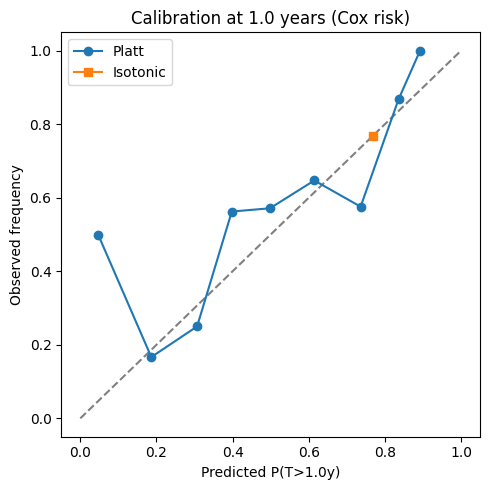

/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/15375825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby("bin")[["y","p"]].mean().dropna()
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/15375825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby("bin")[["y","p"]].mean().dropna()


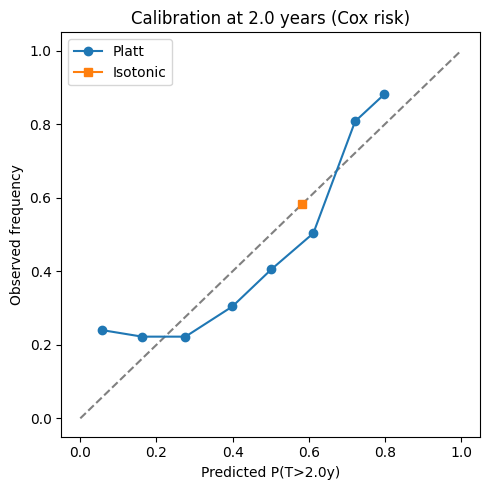

/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/15375825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby("bin")[["y","p"]].mean().dropna()
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/15375825.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return d.groupby("bin")[["y","p"]].mean().dropna()


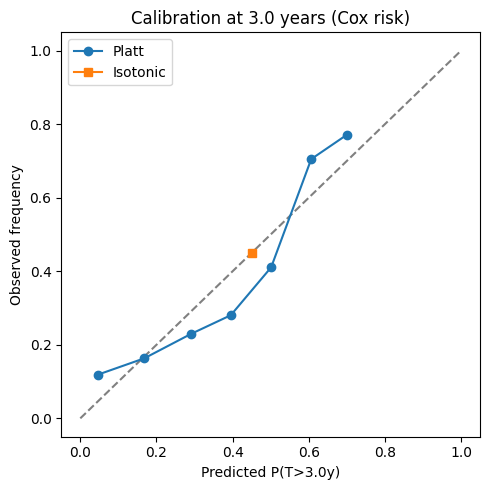

Đã lưu calibration points (nếu có): /mnt/data/calib_points_*


In [140]:
def make_binary_at_t0(time, event, t0):
    # y=1 nếu T>t0 (sống qua mốc) hoặc kiểm duyệt sau t0
    y = ((time > t0) | ((time <= t0) & (event==0))).astype(int)
    # loại các mẫu kiểm duyệt trước t0 (không biết kết cục tại t0)
    mask = ~((time < t0) & (event==0))
    return y[mask], mask

def reliability(y_true, y_pred, bins=np.linspace(0,1,10)):
    d = pd.DataFrame({"y":y_true, "p":y_pred})
    d["bin"] = pd.cut(d["p"], bins)
    return d.groupby("bin")[["y","p"]].mean().dropna()

for t0 in [1.0, 2.0, 3.0]:
    y_calib, mask = make_binary_at_t0(times, events, t0)
    sc = risk_cox[mask]
    # bỏ qua nếu chỉ có 1 lớp (toàn sống/toàn sự kiện)
    if len(np.unique(y_calib)) < 2 or len(y_calib) < 30:
        print(f"[Calibration t0={t0}] Bỏ qua (ít điểm hoặc chỉ một lớp).")
        continue

    # Platt
    pl = LogisticRegression(max_iter=1000).fit(sc.reshape(-1,1), y_calib)
    p_platt = pl.predict_proba(sc.reshape(-1,1))[:,1]

    # Isotonic
    iso = IsotonicRegression(out_of_bounds="clip").fit(sc, y_calib)
    p_iso = iso.transform(sc)

    r_pl  = reliability(y_calib, p_platt)
    r_iso = reliability(y_calib, p_iso)

    # vẽ
    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.plot(r_pl["p"], r_pl["y"], 'o-', label="Platt")
    plt.plot(r_iso["p"], r_iso["y"], 's-', label="Isotonic")
    plt.xlabel(f"Predicted P(T>{t0}y)")
    plt.ylabel("Observed frequency")
    plt.title(f"Calibration at {t0} years (Cox risk)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # lưu calibration points
    # r_pl.assign(t0=t0, method="platt").to_csv(f"./data/calib_points_platt_t{int(t0)}.csv")
    # r_iso.assign(t0=t0, method="isotonic").to_csv(f"./data/calib_points_isotonic_t{int(t0)}.csv")

print("Đã lưu calibration points (nếu có): /mnt/data/calib_points_*")




# 10) Báo cáo & xuất kết quả

* **Hệ số & ý nghĩa Cox**: bảng hệ số, HR = exp(coef), CI, p-value; lưu bảng tóm tắt.
* **Tham số AFT**: ước lượng và ý nghĩa.
* **C-index** (Uno/Harrell) cho Cox và AFT; nêu rõ phương pháp (Uno/Harrell) và lý do fallback.
* **Biểu đồ**:

  * KM theo decile (Cox), KM theo đột biến lớn.
  * Calibration tại t₀ (1y, 2y, 3y).
* **Dự báo test**:

  * Lưu risk score trên test, và nếu cần, xác suất sống sót tại t₀.
  * (Với Cox) dùng baseline survival để suy ra ( \hat S(t|x) = \hat S_0(t)^{\exp(\beta^\top x)} ) và trích riêng tại t₀.


In [141]:
# =====================
# 4) PREDICT SURVIVAL AT t0 (Cox)
# =====================
# Lifelines cho phép tính S_hat(t|x) từ baseline + partial hazard.
# Để nhanh gọn, ta lấy trực tiếp xác suất tại các t0 cho tập test.

t0_list = [1.0, 2.0, 3.0]

# baseline survival theo Cox
baseline_surv = cph.baseline_survival_  # index là thời gian (cùng đơn vị với OS_YEARS)
# Hàm tiện ích: nội suy S0(t) rồi mũ hoá theo exp(beta^T x)
def predict_survival_prob_at_t0(cox_model, X, t0):
    # lấy S0(t0) bằng nội suy gần nhất (forward fill)
    S0 = float(baseline_surv.reindex(baseline_surv.index.union([t0])).sort_index().ffill().loc[t0].values)
    # partial hazard = exp(beta^T x) → S(t|x) = S0(t) ** exp(beta^T x)
    ph = cox_model.predict_partial_hazard(X).values.ravel()
    return (S0 ** ph)

pred_out = test_df[["OS_YEARS","OS_STATUS"]].copy()
for t0 in t0_list:
    pred_out[f"P_surv_gt_{int(t0)}y_cox"] = predict_survival_prob_at_t0(cph, test_df[Xcols], t0)

pred_out["risk_cox"] = risk_cox
pred_out
# pred_out.to_csv("./data/test_predictions_cox.csv", index=False)
# print("Đã lưu: /mnt/data/test_predictions_cox.csv")


/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/1886716355.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0 = float(baseline_surv.reindex(baseline_surv.index.union([t0])).sort_index().ffill().loc[t0].values)
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/1886716355.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S0 = float(baseline_surv.reindex(baseline_surv.index.union([t0])).sort_index().ffill().loc[t0].values)
/var/folders/w7/3q8cywj12cd3qncp6sgxxy2c0000gn/T/ipykernel_15637/1886716355.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error 

,OS_YEARS,OS_STATUS,P_surv_gt_1y_cox,P_surv_gt_2y_cox,P_surv_gt_3y_cox,risk_cox
820,0.926027,0.0,0.922378,0.837469,0.776187,0.379153
1686,6.271233,0.0,0.827639,0.660154,0.552556,0.887719
574,0.550685,1.0,0.672572,0.418653,0.288301,1.861261
428,2.594521,1.0,0.909466,0.811947,0.742621,0.445310
3144,2.454795,0.0,0.848328,0.696921,0.597035,0.771860
...,...,...,...,...,...,...
75,1.197260,0.0,0.757131,0.542946,0.417945,1.305547
3223,2.320548,0.0,0.827000,0.659035,0.551219,0.891344
0,1.115068,1.0,0.561469,0.281658,0.163670,2.708509
2625,3.550685,0.0,0.882204,0.759475,0.675029,0.588121




# 11) Chẩn đoán & khắc phục sự cố thường gặp

* **Matrix singular / không hội tụ (Cox)**:

  * Đã log/clip/outlier control, loại near-zero variance, giảm collinearity (corr cao, VIF), thêm **ridge penalizer**.
  * Nếu vẫn khó: thử **strata** theo biến gây vi phạm PH, hoặc chuyển sang **AFT**.
* **Test không có sự kiện**:

  * Điều chỉnh cách tách dữ liệu (phân tầng + ràng buộc số sự kiện), hoặc thêm thủ tục “chuyển một số ca sự kiện” từ train sang test.
  * Nếu dataset thật sự không có event (toàn sống/kiểm duyệt): **không thể** đánh giá phân biệt bằng C-index; chuyển hướng sang mô tả/censoring-only.
* **IPCW lỗi do mảng rỗng**:

  * Luôn lọc NaN/Inf trước; nếu sau lọc còn quá ít quan sát (<2) thì ghi chú “skip”.
* **Điểm dự báo không có phương sai**:

  * Rà soát pipeline tiền xử lý; xem có bước nào khiến tất cả điểm giống nhau (ví dụ scale sai, cắt cột, logic risk bị hằng).


In [142]:
# =====================
# 5) EXPORT EXTRAS
# =====================
# Importance proxy: |coef| (Cox)
imp = cph.params_.abs().sort_values(ascending=False).rename("abs_coef")
# imp.to_csv("./data/cox_importance_abscoef.csv")
# print("Đã lưu: /mnt/data/cox_importance_abscoef.csv")

# Bảng tóm tắt kết quả chính
summary = pd.DataFrame({
    "metric": ["C-index (Cox)", "C-index (AFT)"],
    "value":  [c_cox, c_aft],
    "estimator": [m1, m2]
})
# summary.to_csv("./data/summary_metrics.csv", index=False)
summary


,metric,value,estimator
0,C-index (Cox),0.299304,harrell(fallback:ValueError)
1,C-index (AFT),0.301706,harrell(fallback:ValueError)





# 12) Xác thực & kiểm thử

* **Cross-validation phân tầng theo sự kiện** (k-fold) và **grouped CV theo CENTER** (nếu có trung tâm/bệnh viện) để kiểm tra tính tổng quát.
* **Phân tích nhạy cảm**: thay đổi nhẹ winzorize/penalizer/biến đổi log, xem C-index và calibration có ổn định.
* **Giải thích mô hình**:

  * Cox: dựa vào HR, kiểm định PH.
  * AFT: hệ số diễn giải theo log-time.
  * (Tuỳ chọn) SHAP/Permutation cho mô hình phi tuyến (nếu dùng thêm GBM/NN sau này).



# 13) Quản trị mô hình & tái lập

* **Ghi version** dữ liệu, danh sách đặc trưng cuối, tham số mô hình, penalizer, t₀ calibration.
* **Lưu pipeline**: sơ đồ ETL → Feature → Split → Train → Evaluate → Report.
* **Kiểm soát chất lượng**: checklist trước khi huấn luyện (event rate, số lượng NA, corr/VIF, thang đo).
* **Tái lập kết quả**: lưu mọi artifact (bảng hệ số, C-index, KM plots, calibration points, file dự báo test).



## Tiêu chí “xong việc”

* Tổng số **event > 0** và **có event ở test**.
* C-index (Uno hoặc fallback Harrell) được tính thành công cho **Cox** và **AFT**.
* Biểu đồ **KM theo decile** cho thấy phân tầng rủi ro hợp lý.
* **Calibration** tại t₀ chạy được và đường reliability gần 45°.
* Báo cáo xuất đầy đủ: hệ số Cox (HR, CI, p), tham số AFT, bảng C-index, file dự báo test, hình KM, hình calibration.

